## Simulate SYSUSD price

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3
import datetime
cwd =  os.getcwd().replace("notebooks/medium_articles","")
os.chdir(cwd)

In [2]:
from uniswappy.math.model import *
from uniswappy.erc import *
from uniswappy.cpt.factory import *
from uniswappy.cpt.factory import *
from uniswappy.process.deposit import *
from uniswappy.process.swap import *
from uniswappy.simulate import SolveDeltas

In [3]:
def create_lp(tkn_x, tkn_y, tkn_x_amt, tkn_y_amt):
    factory = Factory("TKN pool factory", None)
    lp_trial = factory.create_exchange(tkn_x, tkn_y, symbol='LP', address=None)
    lp_trial.add_liquidity(user_nm, tkn_x_amt, tkn_y_amt, tkn_x_amt, tkn_y_amt)
    return lp_trial

def init_amts(tkn_x_amt, p0):
    return tkn_x_amt, p_arr[0,0]*tkn_x_amt 

In [4]:
n_steps = 5000
start_price = 0.2
mu = 0.1; sigma = 0.1
n_paths = 50

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

In [5]:
user_nm = 'user_sim'
tkn = ERC20(f'TKN', "0x09")
dai = ERC20(f'DAI', "0x111")

In [6]:
tkn_x_amt, tkn_y_amt = init_amts(10000, p_arr[0,0])
lp = create_lp(tkn, dai, tkn_x_amt, tkn_y_amt)

p_trial_arr = p_arr[:,0]

sDel = SolveDeltas(lp)
tkn_x = lp.factory.exchange_to_tokens[lp.name][lp.token0]
tkn_y = lp.factory.exchange_to_tokens[lp.name][lp.token1]
tkn_price_arr = []
for p in p_trial_arr[1:]:      
    swap_dx, swap_dy = sDel.calc(p) # Simulation    
    if(swap_dx >= 0):
        expected_amount_dep = SwapDeposit().apply(lp, tkn_x, user_nm, abs(swap_dx))
        expected_amount_out = WithdrawSwap().apply(lp, tkn_y, user_nm, abs(swap_dy))
    elif(swap_dy >= 0):
        expected_amount_dep = SwapDeposit().apply(lp, tkn_y, user_nm, abs(swap_dy))
        expected_amount_out = WithdrawSwap().apply(lp, tkn_x, user_nm, abs(swap_dx)) 
    tkn_price_arr.append(lp.get_price(tkn_x))

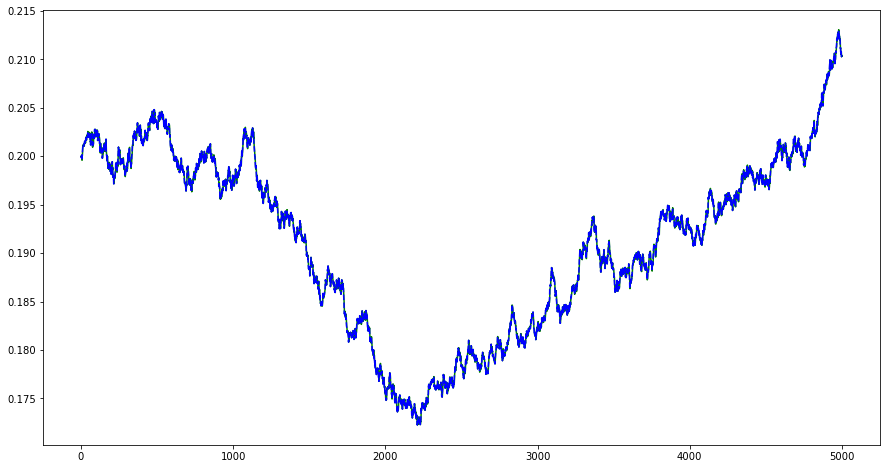

In [7]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(p_trial_arr, color = 'g',linestyle = '-', label='Price (GBM)') 
TKN_ax.plot(tkn_price_arr, color = 'b',linestyle = 'dashed', label='(LP)') 